# scikit-learn を用いたアンサンブルの実装

## ライブラリのインストール

In [1]:
# wget : データのダウンロードに使用
# japanize-matplotlib : 図に日本語を用いるために使用
!pip install -q wget japanize-matplotlib

## ライブラリのインポート

In [2]:
# データのダウンロードに使用
import wget

# データ処理に使用
import pandas as pd

# 作図に使用
import matplotlib as plt
import seaborn as sns
import japanize_matplotlib

# scikit-learn 関連
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    AdaBoostRegressor,
    GradientBoostingRegressor,
    VotingRegressor,
    StackingRegressor
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split # 訓練データとテストデータの分割
from sklearn.metrics import (
    mean_squared_error, # MSE / RMSE
    mean_absolute_error, # MAE
    mean_absolute_percentage_error, # MAPE
)

## データのダウンロードと確認

In [3]:
# Auto MPG データセットのダウンロード
wget.download('https://raw.githubusercontent.com/plotly/datasets/master/auto-mpg.csv')

'auto-mpg (1).csv'

In [4]:
# Auto MPG データセットをデータフレームとして読み込む
df = pd.read_csv('auto-mpg.csv')

# データフレームの列名を変更
df.columns = [
                '燃費[マイル/ガロン]', # 目的変数
                '気筒数',
                '排気量',
                '馬力',
                '重量',
                '加速度',
                '年式'
            ]

In [5]:
# データフレームの中を確認
df

,燃費[マイル/ガロン],気筒数,排気量,馬力,重量,加速度,年式
0,18.0,8,307.0,130.0,3504,12.0,70
1,15.0,8,350.0,165.0,3693,11.5,70
2,18.0,8,318.0,150.0,3436,11.0,70
3,16.0,8,304.0,150.0,3433,12.0,70
4,17.0,8,302.0,140.0,3449,10.5,70
...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790,15.6,82
394,44.0,4,97.0,52.0,2130,24.6,82
395,32.0,4,135.0,84.0,2295,11.6,82
396,28.0,4,120.0,79.0,2625,18.6,82


In [6]:
# 欠損値の確認
df.isnull().sum()

# 「馬力」列に 2 件の欠損値あり
# 数は少ないので、今回は欠損値のある行を削除して対処

燃費[マイル/ガロン]    0
気筒数            0
排気量            0
馬力             2
重量             0
加速度            0
年式             0
dtype: int64

In [7]:
# 欠損値のある行を削除
df_processed = df.dropna()

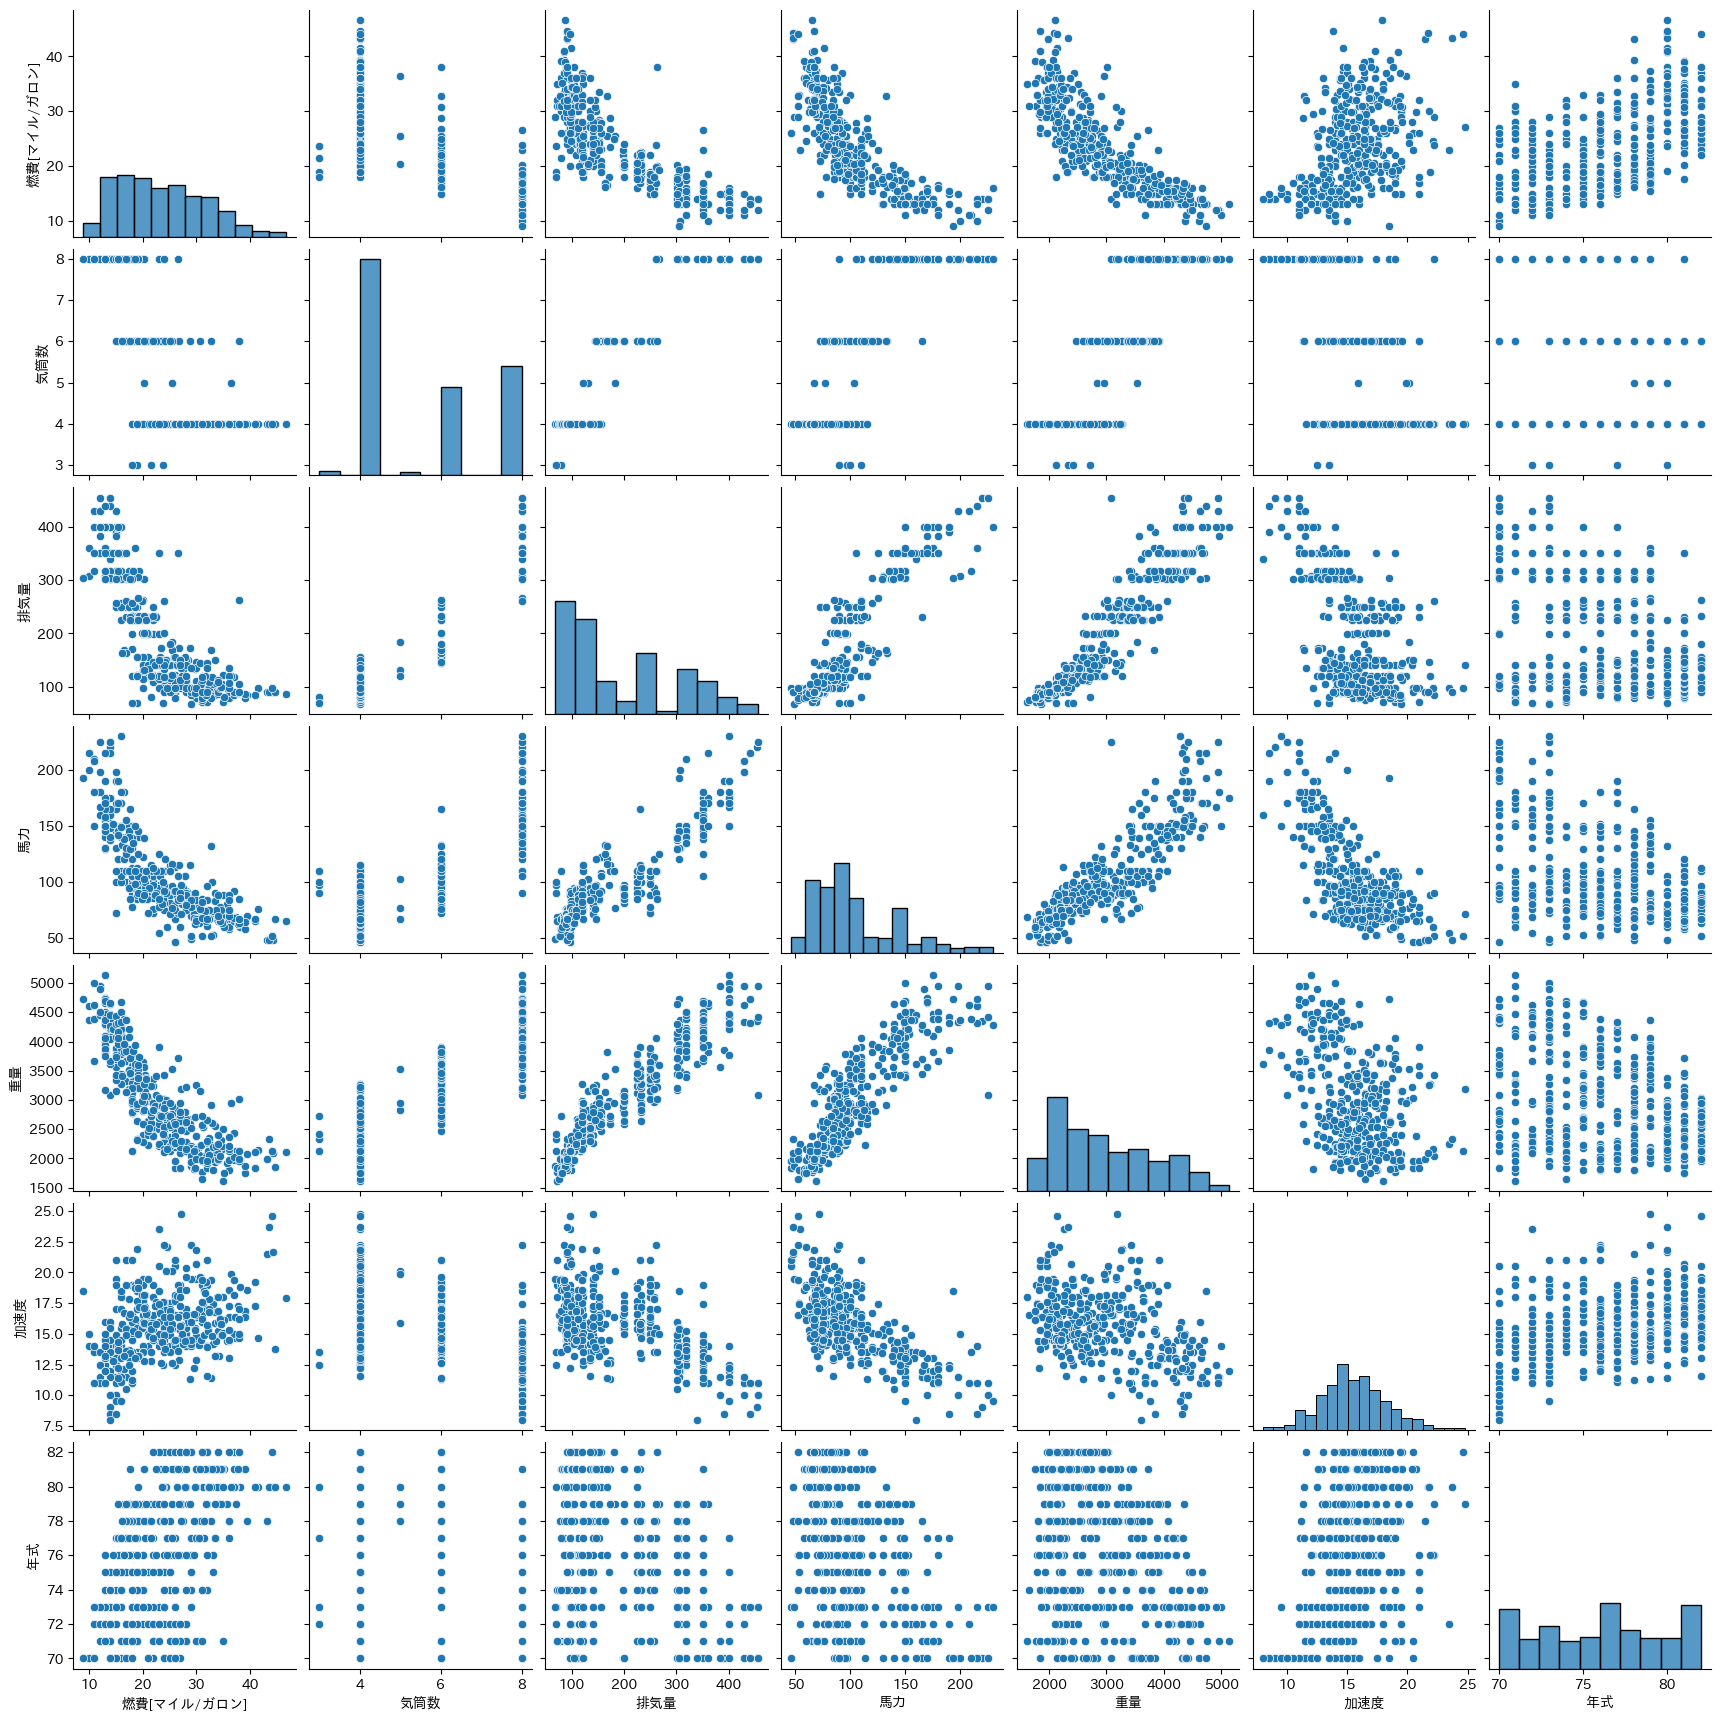

In [8]:
# データセットの散布図・ヒストグラムを確認（ペアプロット）
sns.pairplot(df_processed)

## データの分割

In [9]:
# 乱数による処理を固定化するためのシード値
seed = 1234

# 訓練データとテストデータに、7:3 の割合で分割
df_train, df_test = train_test_split(
    df_processed, # 欠損値除去済みデータフレーム
    test_size=0.3, # テストデータの割合
    random_state=seed # 分割結果を固定化するためのシード値
)

## モデルの学習と評価

### 学習と評価は、何度も行うため関数化

In [10]:
# 評価指標の計算と表示を行う関数
def calculate_metrics(
    y_true, # ラベル
    y_pred # 予測値
):
    # RMSE を計算
    rmse_value = mean_squared_error(
        y_true, # ラベル
        y_pred, # 予測値
        squared=False # False にすると RMSE を計算（True の場合は MSE）
    )
    # MAE を計算
    mae_value = mean_absolute_error(y_true, y_pred)
    # MAPE を計算
    mape_value = mean_absolute_percentage_error(y_true, y_pred)
    # 計算した各種評価指標を表示
    print(f'RMSE: {rmse_value:.4f}')
    print(f'MAE: {mae_value:.4f}')
    print(f'MAPE: {mape_value:.2%}')


# 訓練データによる学習とテストデータによる評価を行う関数
def train_and_eval(
    df_train, # 訓練データのデータフレーム
    df_test, # テストデータのデータフレーム
    model # 学習前のモデルのインスタンス
):
    # 訓練データから説明変数を抽出
    X_train = df_train.drop(['燃費[マイル/ガロン]'], axis=1)
    # 訓練データからラベルを抽出
    y_train = df_train['燃費[マイル/ガロン]']
    # モデルの学習を実行
    model.fit(X_train, y_train)
    # 訓練データに対する予測値を計算
    y_pred_train = model.predict(X_train)
    # 訓練データに対する評価値を計算して表示
    print('===== 訓練データに対する評価 =====')
    calculate_metrics(y_train, y_pred_train)

    # テストデータから説明変数を抽出
    X_test = df_test.drop(['燃費[マイル/ガロン]'], axis=1)
    # テストデータからラベルを抽出
    y_test = df_test['燃費[マイル/ガロン]']
    # テストデータに対する予測値を計算
    y_pred_test = model.predict(X_test)
    # テストデータに対する評価値を計算して表示
    print('===== テストデータに対する評価 =====')
    calculate_metrics(y_test, y_pred_test)

    # 学習済みモデルを return
    return model

### ベースライン｜単一の決定木

In [11]:
# 決定木のインスタンスを作成
single_model = DecisionTreeRegressor(
    random_state=seed # ランダム処理を固定化するためのシード値
)

# 学習と評価を実行
train_and_eval(df_train, df_test, single_model)

===== 訓練データに対する評価 =====
RMSE: 0.0000
MAE: 0.0000
MAPE: 0.00%
===== テストデータに対する評価 =====
RMSE: 3.4904
MAE: 2.5092
MAPE: 10.13%


DecisionTreeRegressor(random_state=1234)

### バギング｜ランダムフォレスト

In [12]:
# ランダムフォレストのインスタンスを作成
bagging_model = RandomForestRegressor(
    n_estimators=100, # 決定木の数は 100 個
    random_state=seed # ランダム処理を固定化するためのシード値
)

# 学習と評価を実行
train_and_eval(df_train, df_test, bagging_model)

===== 訓練データに対する評価 =====
RMSE: 1.0141
MAE: 0.7232
MAPE: 3.17%
===== テストデータに対する評価 =====
RMSE: 2.8797
MAE: 2.0764
MAPE: 8.40%


RandomForestRegressor(random_state=1234)

### ブースティング｜アダブースト

In [13]:
# アダブーストのインスタンスを作成
boosting_model = AdaBoostRegressor(
    n_estimators=100, # 決定木の数は 100 個
    random_state=seed # ランダム処理を固定化するためのシード値
)

# 学習と評価を実行
train_and_eval(df_train, df_test, boosting_model)

===== 訓練データに対する評価 =====
RMSE: 2.1637
MAE: 1.8062
MAPE: 8.22%
===== テストデータに対する評価 =====
RMSE: 3.1331
MAE: 2.3031
MAPE: 9.67%


AdaBoostRegressor(n_estimators=100, random_state=1234)

### ブースティング｜勾配ブースティング

In [14]:
# 勾配ブースティングのインスタンスを作成
grad_boosting_model = GradientBoostingRegressor(
    n_estimators=100, # 決定木の数は 100 個
    random_state=seed # ランダム処理を固定化するためのシード値
)

# 学習と評価を実行
train_and_eval(df_train, df_test, grad_boosting_model)

===== 訓練データに対する評価 =====
RMSE: 1.2710
MAE: 0.9806
MAPE: 4.52%
===== テストデータに対する評価 =====
RMSE: 2.8641
MAE: 2.0959
MAPE: 8.76%


GradientBoostingRegressor(random_state=1234)

### ブレンディング｜複数のモデルの単純平均

In [15]:
# ブレンディングに用いるモデルを('名前', インスタンス)のリストとして整理
estimators = [
    ('single_model', single_model), # 決定木
    ('bagging_model', bagging_model), # ランダムフォレスト
    ('boosting_model', boosting_model), # アダブースト
    ('grad_boosting_model', grad_boosting_model) # 勾配ブースティング
]

# ブレンディングを行うモデルを作成
voting_model = VotingRegressor(estimators)

# 学習と評価を実行
train_and_eval(df_train, df_test, voting_model)

===== 訓練データに対する評価 =====
RMSE: 1.0364
MAE: 0.8413
MAPE: 3.81%
===== テストデータに対する評価 =====
RMSE: 2.8642
MAE: 2.0932
MAPE: 8.49%


VotingRegressor(estimators=[('single_model',
                             DecisionTreeRegressor(random_state=1234)),
                            ('bagging_model',
                             RandomForestRegressor(random_state=1234)),
                            ('boosting_model',
                             AdaBoostRegressor(n_estimators=100,
                                               random_state=1234)),
                            ('grad_boosting_model',
                             GradientBoostingRegressor(random_state=1234))])

### スタッキング

In [16]:
# スタッキングに用いるベースモデルを('名前', インスタンス)のリストとして整理
estimators = [
    ('single_model', single_model), # 決定木
    ('bagging_model', bagging_model), # ランダムフォレスト
    ('boosting_model', boosting_model), # アダブースト
    ('grad_boosting_model', grad_boosting_model) # 勾配ブースティング
]

# ベースモデルをもとに、最終予測を行うメタモデルを定義
final_estimator = make_pipeline(
    StandardScaler(), # 標準化
    LinearRegression() # 今回はメタモデルとして線形回帰を使用
)

# スタッキングしたモデルを定義
stack_model = StackingRegressor(
    estimators, # ベースモデル
    final_estimator, # メタモデル
    passthrough=False # メタモデルの特徴量にもとの学習データの特徴量を含めるか（Trueなら含める）
)

# 学習と評価を実行
train_and_eval(df_train, df_test, stack_model)

===== 訓練データに対する評価 =====
RMSE: 1.1824
MAE: 0.9347
MAPE: 4.27%
===== テストデータに対する評価 =====
RMSE: 2.8219
MAE: 2.0713
MAPE: 8.55%


StackingRegressor(estimators=[('single_model',
                               DecisionTreeRegressor(random_state=1234)),
                              ('bagging_model',
                               RandomForestRegressor(random_state=1234)),
                              ('boosting_model',
                               AdaBoostRegressor(n_estimators=100,
                                                 random_state=1234)),
                              ('grad_boosting_model',
                               GradientBoostingRegressor(random_state=1234))],
                  final_estimator=Pipeline(steps=[('standardscaler',
                                                   StandardScaler()),
                                                  ('linearregression',
                                                   LinearRegression())]))

### より複雑なスタッキング＆ブレンディング

In [17]:
# ベースモデルに、さらに 10 個のランダムフォレストを追加
estimators += [
    (f'rf{i}', RandomForestRegressor(
            n_estimators=10 * (i + 1), # 木の総数を変更
            random_state=seed + i # 木の多様性を出すために、シード値も変更
        )
    ) for i in range(10)
]

# ベースモデルに、さらに 10 個の k-近傍法を追加
estimators += [
    (f'knn{i}', KNeighborsRegressor(
            n_neighbors=i + 1 # 何個の近傍を取って予測するか
        )
    ) for i in range(10)
]

# 合計 24 個のモデルでスタッキングモデルを作成
# １つ目のスタッキングモデルのメタモデルはアダブーストを使用
first_stacking_head = AdaBoostRegressor(random_state=seed)
first_stacking_model = StackingRegressor(
    estimators=estimators, # ベースモデル
    final_estimator=first_stacking_head, # メタモデル
    passthrough=True # メタモデルの特徴量にもとの学習データの特徴量を含めるか（Trueなら含める）
)
# 1 つ目のスタッキングモデルを学習
print('########## 1st stacking model training ##########')
first_stacking_model = train_and_eval(df_train, df_test, first_stacking_model)

# 合計 24 個のモデルでもうひとつ別のスタッキングモデルを作成
# 2つ目のスタッキングモデルのメタモデルはランダムフォレストを使用
second_stacking_head = RandomForestRegressor(random_state=seed)
second_stacking_model = StackingRegressor(
    estimators=estimators, # ベースモデル
    final_estimator=second_stacking_head, # メタモデル
    passthrough=True # メタモデルの特徴量にもとの学習データの特徴量を含めるか（Trueなら含める）
)

# 2 つ目のスタッキングモデルを学習
print('########## 2nd stacking model training ##########')
second_stacking_model = train_and_eval(df_train, df_test, second_stacking_model)

# 2 つのスタッキングモデルをブレンディング
estimators = [
    ('stack1', first_stacking_model), # 1 つ目のスタッキングモデル（アダブースト）
    ('stack2', second_stacking_model), # 2 つ目のスタッキングモデル（ランダムフォレスト）
]
# ブレンディングモデルを作成
final_stacking_model = VotingRegressor(
    estimators=estimators,
)

# ブレンディングモデルの学習と評価を実行
print('########## Final model training ##########')
train_and_eval(df_train, df_test, final_stacking_model)

########## 1st stacking model training ##########
===== 訓練データに対する評価 =====
RMSE: 1.7100
MAE: 1.3469
MAPE: 5.95%
===== テストデータに対する評価 =====
RMSE: 2.9496
MAE: 2.1258
MAPE: 8.66%
########## 2nd stacking model training ##########
===== 訓練データに対する評価 =====
RMSE: 1.5506
MAE: 1.0895
MAPE: 4.42%
===== テストデータに対する評価 =====
RMSE: 2.9346
MAE: 2.1266
MAPE: 8.79%
########## Final model training ##########
===== 訓練データに対する評価 =====
RMSE: 1.5585
MAE: 1.1703
MAPE: 4.93%
===== テストデータに対する評価 =====
RMSE: 2.8954
MAE: 2.0692
MAPE: 8.48%


VotingRegressor(estimators=[('stack1',
                             StackingRegressor(estimators=[('single_model',
                                                            DecisionTreeRegressor(random_state=1234)),
                                                           ('bagging_model',
                                                            RandomForestRegressor(random_state=1234)),
                                                           ('boosting_model',
                                                            AdaBoostRegressor(n_estimators=100,
                                                                              random_state=1234)),
                                                           ('grad_boosting_model',
                                                            GradientBoostingRegressor(random_state=1234)),
                                                           ('rf0',
                                                            RandomForestRegr...
                                                            KNeighborsRegressor(n_neighbors=4)),
                                                           ('knn4',
                                                            KNeighborsRegressor()),
                                                           ('knn5',
                                                            KNeighborsRegressor(n_neighbors=6)),
                                                           ('knn6',
                                                            KNeighborsRegressor(n_neighbors=7)),
                                                           ('knn7',
                                                            KNeighborsRegressor(n_neighbors=8)),
                                                           ('knn8',
                                                            KNeighborsRegressor(n_neighbors=9)),
                                                           ('knn9',
                                                            KNeighborsRegressor(n_neighbors=10))],
                                               final_estimator=RandomForestRegressor(random_state=1234),
                                               passthrough=True))])